![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [Vipin Kumar Transaction Data](https://www.kaggle.com/vipin20/transaction-data):

## Context

This is a item purchased transactions data. It has 8 columns.
This data makes you familer with transactions data.

## Content

Data description is :-

* UserId -It is a unique ID for all User Id
* TransactionId -It contains unique Transactions ID
* TransactionTime -It contains Transaction Time
* ItemCode -It contains item code that item will be purchased
* ItemDescription -It contains Item description
* NumberOfItemPurchased -It contains total number of items Purchased
* CostPerltem -Cost per item Purchased
* Country -Country where item purchased


# Global Imports

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split

In [2]:
%reload_kedro

2022-02-23 16:51:50,011 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-02-23 16:51:50,058 - root - INFO - ** Kedro project productrec
2022-02-23 16:51:50,059 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-02-23 16:51:50,068 - root - INFO - Registered line magic `run_viz`


In [ ]:
%run Common-Functions.ipynb

In [3]:
catalog.list()

['products',
 'transactions',
 'clean_transaction',
 'train',
 'test',
 'products_altered',
 'transactions_altered',
 'user_factors',
 'item_factors',
 'product_train',
 'score',
 'brazilian_kaggle_order_data',
 'brazilian_kaggle_product_data',
 'brazilian_kaggle_customer_data',
 'brazilian_hyperparameters',
 'ecommerce_kaggle_data',
 'ecommerce_hyperparameters',
 'electronics_kaggle_data',
 'electronics_hyperparameters',
 'instacart_kaggle_order_data',
 'instacart_kaggle_product_data',
 'instacart_hyperparameters',
 'jewelry_kaggle_data',
 'jewelry_hyperparameters',
 'journey_kaggle_transaction_data',
 'journey_kaggle_product_data',
 'journey_hyperparameters',
 'retailrocket_kaggle_event_data',
 'retailrocket_hyperparameters',
 'vipin20_kaggle_data',
 'vipin20_hyperparameters',
 'parameters',
 'params:seed',
 'params:alpha',
 'params:factors',
 'params:regularization',
 'params:iterations',
 'params:test_size',
 'params:filter_value',
 'params:minimum_order_size',
 'params:maximum_ord

In [2]:
transactions = catalog.load("transactions")
print('Loaded',len(transactions),'rows')
transactions.head()

2022-03-01 14:09:57,737 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
Loaded 2633521 rows


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,quantity,description
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,1,samsungelectronics.tablet
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,1,samsungelectronics.tablet
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,1,huaweielectronics.audio.headphone
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,1,huaweielectronics.audio.headphone
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18,1,NaN


                                product_id  size
order_id                                        
2294359932054536986  (1515966223509089906)     1
2294444024058086220  (2273948319057183658)     1
2294584263154074236  (2273948316817424439)     1
2295716521449619559  (1515966223509261697)     1
2295740594749702229  (1515966223509104892)     1
There are 398421  unique transactions

Here are the counts of transactions ordered from largest to smallest
[558 480 461 ...   1   1   1]

And a graph of what the curve looks like:


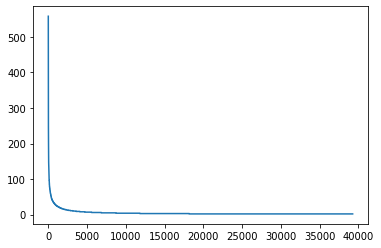

In [16]:
grouped = transactions.groupby('order_id').agg({"product_id": lambda x: frozenset(x)})
grouped['size'] = grouped.apply(lambda row: len(row['product_id']), axis=1)
print(grouped.head())

transaction_counts = grouped[grouped["size"]>1]['product_id'].value_counts().to_numpy()
print('There are', len(transaction_counts), ' unique transactions\n')
print('Here are the counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts[transaction_counts > 1]) 
plt.show()

In [11]:
grouped['size'] = grouped.apply(lambda row: len(row['product_id']), axis=1)
grouped.head()

,product_id,size
order_id,,
2294359932054536986,(1515966223509089906),1
2294444024058086220,(2273948319057183658),1
2294584263154074236,(2273948316817424439),1
2295716521449619559,(1515966223509261697),1
2295740594749702229,(1515966223509104892),1


In [14]:
grouped[grouped["size"]>1].head()

,product_id,size
order_id,,
2297951447913857849,"(2273948319057183658, 1515966223509088613)",2
2297988436574864215,"(1515966223509089486, 1515966223509259423)",2
2297991320922226852,"(1515966223509123236, 1515966223509127751)",2
2298002502676644300,"(1515966223509107888, 1515966223509088628)",2
2298009757589438761,"(1515966223509260344, 1515966223509104402, 151...",4


In [6]:
# Create an index of unique orders and build a dataframe with ['order_id', 'order_index']
unique_orders = grouped.product_id.unique().tolist()
indexed_orders = grouped.apply({'product_id': lambda x: unique_orders.index(x)})
indexed_orders = indexed_orders.rename(columns={"product_id":"order_index"})

# Add the order_index to the transaction dataframe
transactions = transactions.merge(indexed_orders, how='left', on='order_id')

In [7]:
order_list = list(np.sort(indexed_orders.order_index.unique())) # Get our unique customers
print(len(order_list), "unique orders")

product_list = list(transactions.product_id.unique()) # Get our unique products that were purchased
print(len(product_list), "unique products")

# Get the associated row indices
rows = transactions.order_index.astype(CategoricalDtype(categories=order_list, ordered=True)).cat.codes 
print(len(rows), "transactions")

# Get the associated column indices
cols = transactions.product_id.astype(CategoricalDtype(categories=product_list, ordered=True)).cat.codes 
print(len(cols), "products")

quantity_list = list(transactions.quantity) # All of our purchases
print(len(quantity_list), "items purchased")

shape=(len(order_list), len(product_list))

print("Order Count: {}, Product Count: {}, Quantity Count: {}".format(len(rows), len(cols), len(quantity_list)))
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape)

18149 unique orders
3242 unique products
1016476 transactions
1016476 products
1016476 items purchased
Order Count: 1016476, Product Count: 1016476, Quantity Count: 1016476


In [8]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.17667444641958

In [9]:
print(purchases_sparse.shape)

(18149, 3242)


# Training & Test Datasets

We will use the function below to create a training and test dataset from the tutorial linked at the top. The test dataset masks some percentage of purchases to tested later with a recommendation.

In [10]:
product_train, product_test = train_test_split(purchases_sparse, test_size=0.1, random_state=42)
print(product_train.shape, product_test.shape)

(16334, 3242) (1815, 3242)


In [11]:
# product_train, product_test, transactions_altered, products_altered = make_train(purchases_sparse, pct_test = 0.2)
# print('Total number of masked items:',product_test.count_nonzero()-product_train.count_nonzero())


# Implicit Recommendation Model

The code below creates and trains one of the models available from the Implicit package. Currently using hyperparameters suggested by various tutorials with no tuning.

In [12]:
alpha = 1
factors = 512
regularization = 0.003
iterations = 200

model = implicit.als.AlternatingLeastSquares(factors=factors,
                                    regularization=regularization,
                                    iterations=iterations, calculate_training_loss=True)

## BayesianPersonalizedRanking was pretty bad
# model = implicit.bpr.BayesianPersonalizedRanking(factors=31,
#                                     regularization=0.1,
#                                     iterations=50)


# model = implicit.lmf.LogisticMatrixFactorization(factors=32,
#                                     regularization=0.1,
#                                     iterations=50)

model.fit((product_train * alpha).astype('double'))

user_vecs = model.to_cpu().user_factors
item_vecs = model.to_cpu().item_factors

# Deprecated function below
# user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
#                                                           factors=32, 
#                                                           regularization = 0.1, 
#                                                           iterations = 50)

  0%|          | 0/200 [00:00<?, ?it/s]

2022-02-23 16:54:47,814 - implicit - INFO - Final training loss 0.0056


In [13]:
print(model.user_factors.shape)
print(model.item_factors.shape)

(16334, 512)
(3242, 512)


# Scoring the Model

Following the tutorial, we will use the area under the Receiver Operating Characteristic curve. 

In [163]:

def score_model(model, test_orders, test_size=0.1):

    skipped = 0
    
    tplist = []
    tnlist = []
    fplist = []
    fnlist = []

    for row in test_orders:

        TP = FP = FN = TN = 0

        # Get the list of nonzero products
        nonzero = row.nonzero()[1]
        order_size = len(nonzero)
        
        # Need to skip if there aren't multiple products
        if order_size < 2:
            skipped+=1
            continue

        temp = row.copy()
        if test_size > 0:
            mask_count = max(1, int(order_size * test_size))
            mask_list = random.sample(list(nonzero), mask_count)
            temp[np.zeros(mask_count), mask_list] = 0
            temp.eliminate_zeros()

        new_id = model.user_factors.shape[0]
        model.partial_fit_users([new_id], temp.astype('double'))
        recs, prob = model.recommend(new_id, temp, N=order_size, filter_already_liked_items=False)
        for rec in recs:
            if rec in nonzero:
                TP+=1
            else:
                FP+=1

        for product in nonzero:
            if product not in recs:
                FN+=1

        TN = model.item_factors.shape[0] - TP - FP - FN
        
        tplist.append(TP)
        tnlist.append(TN)
        fplist.append(FP)
        fnlist.append(FN)
        
    count = test_orders.shape[0] - skipped
    
    true_positive = np.mean(tplist)
    false_positive = np.mean(fplist)
    false_negative = np.mean(fnlist)
    true_negative =  np.mean(tnlist)
    
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    return {
        'true_positive':true_positive,
        'false_positive':false_positive,
        'false_negative':false_negative,
        'true_negative':true_negative,
        'sensitivity':sensitivity,
        'specificity':specificity
    }

In [166]:
score = score_model(model, product_test, test_size=0.1)
# print("Model Sensitivity is", np.mean(TPList) / (np.mean(TPList) + np.mean(FNList)))
# print("Model Specificity is", np.mean(TNList) / (np.mean(TNList) + np.mean(FPList)))
# print("Model ROC is", np.mean(TPList) / np.mean(FPList))

In [167]:
print(model.item_factors.shape[0])
print(score)

3242
{'true_positive': 23.294653014789535, 'false_positive': 4.1331058020477816, 'false_negative': 4.1331058020477816, 'true_negative': 3210.4391353811147, 'sensitivity': 0.8493093865361483, 'specificity': 0.9987142594746832}


In [ ]:
catalog.save("user_factors", user_vecs)
catalog.save("item_factors", item_vecs)
catalog.save("product_train", product_train*alpha)

# Spot Checking

Now that we have a pretty good idea of the model performance overall, we can spot check a few things like finding similar items and checking item recommendations for an existing invoice.

In [18]:
item_lookup = catalog.load("products")
item_lookup.head()

2022-02-23 16:59:02,483 - kedro.io.data_catalog - INFO - Loading data from `products` (CSVDataSet)...


,product_id,description
0,465549,FAMILY ALBUM WHITE PICTURE FRAME
1,482370,LONDON BUS COFFEE MUG
2,490728,SET 12 COLOUR PENCILS DOLLY GIRL
3,459186,UNION JACK FLAG LUGGAGE TAG
4,1733592,WASHROOM METAL SIGN


In [23]:
related = model.similar_items(1284)
print(related)
print(len(product_list))
for index, prob in zip(related[0], related[1]):
    print("Index {}".format(index))
    product = product_list[index]
    print("Product {}".format(product))
    item = item_lookup[item_lookup.product_id == product_list[index]].values
    print("{} {}% {}".format(index, prob, item[0][1]))



(array([1284, 1222,  602, 1372, 1089, 1441, 2635, 2582, 2049, 1590],
      dtype=int32), array([1.        , 0.5544831 , 0.46807647, 0.4660211 , 0.1638395 ,
       0.15135196, 0.12520699, 0.12250991, 0.12022331, 0.11861705],
      dtype=float32))
3242
Index 1284
Product 489153
1284 1.0% SET OF 12 FAIRY CAKE BAKING CASES
Index 1222
Product 489195
1222 0.5544831156730652% SET OF 12 MINI LOAF BAKING CASES
Index 602
Product 489174
602 0.4680764675140381% SET OF 6 SNACK LOAF BAKING CASES
Index 1372
Product 489216
1372 0.4660210907459259% SET OF 6 TEA TIME BAKING CASES
Index 1089
Product 489237
1089 0.16383950412273407% SET 40 HEART SHAPE PETIT FOUR CASES
Index 1441
Product 483189
1441 0.1513519585132599% I LOVE LONDON BABY GIFT SET
Index 2635
Product 1492050
2635 0.12520699203014374% SMALL SINGLE FLAME CANDLE HOLDER
Index 2582
Product 1776558
2582 0.1225099116563797% BOYS ALPHABET IRON ON PATCHES
Index 2049
Product 495894
2049 0.12022331357002258% SET 10 CARDS 12 DAYS WRAP  17058
Index 1590


In [81]:
user_items = (product_train * alpha).astype('double').T.tocsr()
order_list = list(transactions.order_id.unique()) # Get our unique products that were purchased
item_list = list(transactions.product_id.unique()) # Get our unique products that were purchased

def recommend(order):
    products = transactions[transactions.order_id == order_list[order]]['product_id'].values
    indeces = []
    for product in list(products):
        index = item_list.index(product)
        indeces.append(index)

    print('Order Contents:')
    print(transactions[transactions.order_id == order_list[order]].loc[:, ['product_id', 'description']])
    print('Recommendations:')
    recommendations = model.recommend(order, product_train[order], filter_items=indeces)
    for index, prob in zip(recommendations[0], recommendations[1]):
        product = item_list[index]
        item = item_lookup[item_lookup.product_id == product_list[index]].values
        print("{} {}% {}".format(index, prob, item[0][1]))


In [82]:
recommend(1)

Order Contents:
        product_id                          description
1           482370                LONDON BUS COFFEE MUG
6086       1784748   SET OF 72 PINK HEART PAPER DOILIES
22656       463155   MINI CAKE STAND  HANGING STRAWBERY
32375       475629         STRAWBERRY FAIRY CAKE TEAPOT
38122       475545  CERAMIC HEART FAIRY CAKE MONEY BANK
...            ...                                  ...
968927      475293               HAND WARMER UNION JACK
970580      754404        HANGING FAIRY CAKE DECORATION
970970      445872       STRAWBERRY CERAMIC TRINKET BOX
973276      494214               WALL ART STOP FOR TEA 
988142      786429   CERAMIC CAKE STAND + HANGING CAKES

[114 rows x 2 columns]
Recommendations:
2638 0.5217434167861938% WRAP MAGIC FOREST 
2584 0.4958226978778839% WRAP BIRD GARDEN 
2050 0.4855252802371979% SET OF 4 KNICK KNACK TINS LEAVES 
2009 0.4501400291919708% STORAGE TIN VINTAGE LEAF
2442 0.4413449764251709% WRAP FLOWER SHOP  
1175 0.416348397731781% SKETCHB

In [83]:
recommend(2200)

Order Contents:
        product_id                         description
2666       1786302  PEARL CRYSTAL PUMPKIN T-LIGHT HLDR
10359      1786302  PEARL CRYSTAL PUMPKIN T-LIGHT HLDR
64203       444003     ANTIQUE GLASS HEART DECORATION 
64339       465318  3 HEARTS HANGING DECORATION RUSTIC
66136       479535     HOT WATER BOTTLE I AM SO POORLY
78082       476574                        WICKER STAR 
165719      444003     ANTIQUE GLASS HEART DECORATION 
199280     1784370    SINGLE HEART ZINC T-LIGHT HOLDER
234469      470799                    LIPSTICK PEN RED
239438      471870               HEART OF WICKER LARGE
242647     1784538    HANGING HEART JAR T-LIGHT HOLDER
255234      465738     VICTORIAN GLASS HANGING T-LIGHT
256073      451185    RETROSPOT HEART HOT WATER BOTTLE
314667      454671       HANGING GLASS ETCHED TEALIGHT
330542      451185    RETROSPOT HEART HOT WATER BOTTLE
362925      445452     PACK OF 72 RETROSPOT CAKE CASES
417293     1784538    HANGING HEART JAR T-LIGHT H

In [84]:
transactions['total'] = transactions['quantity'] * transactions['price']

KeyError: 'price'

In [ ]:
recommended_price = []
for user in range(0, len(transaction_list)):
    recommendations = model.recommend(user, user_items)
    index = recommendations[0][0]
    price = price_lookup[price_lookup.ItemCode == str(item_list[index])].values
    item = item_lookup[item_lookup.ItemCode == str(item_list[index])].values
    recommended_price.append(price[0][1])
    
total_recommended = np.sum(recommended_price)

print('After recommending',len(transaction_list),'items, there would be an increase of',
      "${:,.2f}".format(total_recommended*test),'in additional purchases.')

In [ ]:
totals = transactions.groupby(transactions.TransactionId)['ItemTotal'].sum()
total = totals.sum()

print('Added to the initial total of all',len(transaction_list),'purchases valued at',
      "${:,.2f}".format(total),', the percentage increase in revenue would be', "{:,.4f}%".format(total_recommended / total ))
